In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import sys
import os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from few.trajectory.inspiral import EMRIInspiral
from few.waveform import GenerateEMRIWaveform
from few.summation.aakwave import AAKSummation
from few.waveform import Pn5AAKWaveform, AAKWaveformBase
from few.utils.utility import *

os.chdir("../")
path = os.getcwd()
sys.path.insert(0, path)
import GWGen
from GWGen.WFGenerator import *

# set initial parameters
M = 1e5
mu = 1e1
a = 1e-6
p0 = 14.0
e0 = 1e-5
iota0 = 0.1
Y0 = np.cos(iota0)
Phi_phi0 = 0.
Phi_theta0 =0.
Phi_r0 = 0.


qS = 0.2
phiS = 0.2
qK = 0.8
phiK = 0.8
dist = 1.0
mich = False
dt = 15.0
T = 2.0

# FEW 5PN AAK model

In [ ]:
use_gpu = False

# keyword arguments for inspiral generator (RunKerrGenericPn5Inspiral)
inspiral_kwargs = {
    "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
}

# keyword arguments for summation generator (AAKSummation)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

wave_generator = Pn5AAKWaveform(inspiral_kwargs=inspiral_kwargs, sum_kwargs=sum_kwargs, use_gpu=False)
FEWwaveform = wave_generator(M, mu, a, p0, e0, Y0, qS, phiS, qK, phiK, dist,Phi_phi0=Phi_phi0, Phi_theta0=Phi_theta0, Phi_r0=Phi_r0, mich=mich, dt=dt, T=T)

t = np.arange(len(FEWwaveform)) * dt;
plt.plot(t, FEWwaveform.real);
plt.plot(t, FEWwaveform.imag);
plt.title("FEW AAK model");
ticks = plt.xticks()[0][1:-1];
newlabs = [int(i)/100 for i in (ticks*100/(60*60*24*365))];
plt.xticks(ticks, newlabs);
plt.xlabel("years");
plt.ylabel("strain");

# PN example in Documentation of FEW

/mnt/Data_Volume/Computer_Programs/Anaconda/envs/few_env/lib/python3.7/site-packages/few-1.4.6-py3.7-linux-x86_64.egg/few/summation/aakwave.py:228: UserWarning: Inclination trajectory includes values within 1e-6 of the poles. We shift these values automatically away from poles by 1e-6.
  "Inclination trajectory includes values within 1e-6 of the poles. We shift these values automatically away from poles by 1e-6."
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


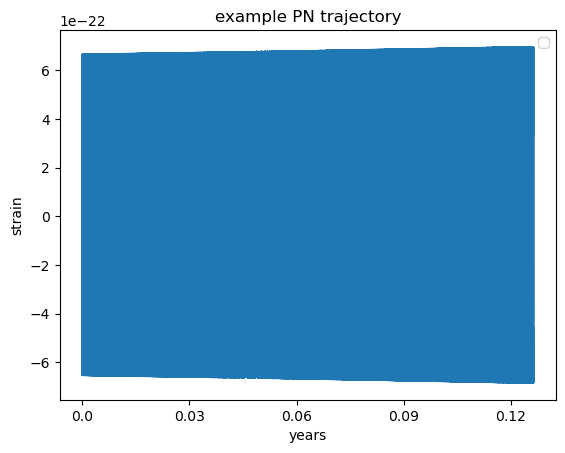

In [7]:
# we need to import an integrator and elliptic integrals
from mpmath import *
from scipy.integrate import DOP853

# base classes
from few.utils.baseclasses import TrajectoryBase
from few.utils.baseclasses import SchwarzschildEccentric
from few.waveform import SchwarzschildEccentricWaveformBase

# settings for elliptic integrals
mp.dps = 25
mp.pretty = True

# constants from our package
from few.utils.constants import MTSUN_SI, YRSID_SI, Pi


class testPN:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def __call__(self, t, y):

        # mass ratio
        epsilon = self.epsilon

        # extract the four evolving parameters
        p, e, Phi_phi, Phi_r = y

        # guard against bad integration steps
        if e >= 1.0 or e < 1e-2 or p < 6.0 or (p - 6 - 2* e) < 0.1:
            return [0.0, 0.0,0.,0.]


        # perform elliptic calculations
        EllipE = ellipe(4*e/(p-6.0+2*e))
        EllipK = ellipk(4*e/(p-6.0+2*e))
        EllipPi1 = ellippi(16*e/(12.0 + 8*e - 4*e*e - 8*p + p*p), 4*e/(p-6.0+2*e))
        EllipPi2 = ellippi(2*e*(p-4)/((1.0+e)*(p-6.0+2*e)), 4*e/(p-6.0+2*e))

        # Azimuthal frequency
        Omega_phi = (2*Power(p,1.5))/(Sqrt(-4*Power(e,2) + Power(-2 + p,2))*(8 + ((-2*EllipPi2*(6 + 2*e - p)*(3 + Power(e,2) - p)*Power(p,2))/((-1 + e)*Power(1 + e,2)) - (EllipE*(-4 + p)*Power(p,2)*(-6 + 2*e + p))/(-1 + Power(e,2)) +
              (EllipK*Power(p,2)*(28 + 4*Power(e,2) - 12*p + Power(p,2)))/(-1 + Power(e,2)) + (4*(-4 + p)*p*(2*(1 + e)*EllipK + EllipPi2*(-6 - 2*e + p)))/(1 + e) + 2*Power(-4 + p,2)*(EllipK*(-4 + p) + (EllipPi1*p*(-6 - 2*e + p))/(2 + 2*e - p)))/
            (EllipK*Power(-4 + p,2))))

        # Post-Newtonian calculations
        yPN = pow(Omega_phi,2./3.)

        EdotPN = (96 + 292*Power(e,2) + 37*Power(e,4))/(15.*Power(1 - Power(e,2),3.5)) * pow(yPN, 5)
        LdotPN = (4*(8 + 7*Power(e,2)))/(5.*Power(-1 + Power(e,2),2)) * pow(yPN, 7./2.)

        # flux
        Edot = -epsilon*(EdotPN)
        Ldot = -epsilon*(LdotPN)

        # time derivatives
        pdot = (-2*(Edot*Sqrt((4*Power(e,2) - Power(-2 + p,2))/(3 + Power(e,2) - p))*(3 + Power(e,2) - p)*Power(p,1.5) + Ldot*Power(-4 + p,2)*Sqrt(-3 - Power(e,2) + p)))/(4*Power(e,2) - Power(-6 + p,2))

        edot = -((Edot*Sqrt((4*Power(e,2) - Power(-2 + p,2))/(3 + Power(e,2) - p))*Power(p,1.5)*
        (18 + 2*Power(e,4) - 3*Power(e,2)*(-4 + p) - 9*p + Power(p,2)) +
        (-1 + Power(e,2))*Ldot*Sqrt(-3 - Power(e,2) + p)*(12 + 4*Power(e,2) - 8*p + Power(p,2)))/
        (e*(4*Power(e,2) - Power(-6 + p,2))*p))

        Phi_phi_dot = Omega_phi;

        Phi_r_dot = (p*Sqrt((-6 + 2*e + p)/(-4*Power(e,2) + Power(-2 + p,2)))*Pi)/(8*EllipK + ((-2*EllipPi2*(6 + 2*e - p)*(3 + Power(e,2) - p)*Power(p,2))/((-1 + e)*Power(1 + e,2)) - (EllipE*(-4 + p)*Power(p,2)*(-6 + 2*e + p))/(-1 + Power(e,2)) +
        (EllipK*Power(p,2)*(28 + 4*Power(e,2) - 12*p + Power(p,2)))/(-1 + Power(e,2)) + (4*(-4 + p)*p*(2*(1 + e)*EllipK + EllipPi2*(-6 - 2*e + p)))/(1 + e) + 2*Power(-4 + p,2)*(EllipK*(-4 + p) + (EllipPi1*p*(-6 - 2*e + p))/(2 + 2*e - p)))/Power(-4 + p,2))

        dydt = [pdot, edot, Phi_phi_dot, Phi_r_dot]

        return dydt

# this is the actual class that implements a PN trajectory. It uses the PN class in the integrator.
class testPnTrajectory(TrajectoryBase):

    # for common interface with *args and **kwargs
    def __init__(self, *args, **kwargs):
        pass

    # required by the trajectory base class
    def get_inspiral(self, M, mu, a, p0, e0, x0, T=1.0, **kwargs):

        # set up quantities and integrator
        y0 = [p0, e0, 0.0, 0.0]

        T = T * YRSID_SI / (M * MTSUN_SI)
        Msec = M * MTSUN_SI

        epsilon = mu/M
        self.PNEvaluator=testPN(epsilon)
        npoints = 50
        integrator = DOP853(self.PNEvaluator, 0.0, y0, T, max_step = T/npoints)

        t_out, p_out, e_out = [0.], [p0], [e0]
        Phi_phi_out, Phi_r_out = [0.], [0.]
        
        # run the integrator down to T or separatrix
        run = True
        while integrator.t < T and run:
            integrator.step()
            p, e, Phi_phi, Phi_r = integrator.y
            t_out.append(integrator.t * Msec)
            p_out.append(p)
            e_out.append(e)
            Phi_phi_out.append(Phi_phi)
            Phi_r_out.append(Phi_r)
            
           #catch separatrix crossing and halt integration
            if (p - get_separatrix(a,e,1.))<0.1:
                run=False
                exit_reason="Passed separatrix"
	
            if e<0 or e>=1:
                run=False
                exit_reason="Ecccentricity exceeded bounds"

        # read out data. It must return length 6 tuple
        t = np.asarray(t_out)
        p = np.asarray(p_out)
        e = np.asarray(e_out)
        Phi_phi = np.asarray(Phi_phi_out)
        Phi_r = np.asarray(Phi_r_out)

        # need to add polar info
        Phi_theta = Phi_phi.copy()  # by construction
        x = np.ones_like(Phi_theta)

        return (t, p, e, x, Phi_phi, Phi_theta, Phi_r)
    
    
class testWFModel(AAKWaveformBase):
    def __init__(
        self,
        inspiral_kwargs={},
        amplitude_kwargs={},
        sum_kwargs={},
        Ylm_kwargs={},
        use_gpu=False,
        *args,
        **kwargs
    ):

        AAKWaveformBase.__init__(
            self,
            testPnTrajectory,
            AAKSummation,
            inspiral_kwargs=inspiral_kwargs,
            use_gpu=use_gpu,
            *args,
            **kwargs
        )

    @property
    def gpu_capability(self):
        return True

    @property
    def allow_batching(self):
        return False
    
    
    
test = testWFModel()

testwf = test(M, mu, a, p0, e0, Y0, qS, phiS, qK, phiK, dist,Phi_phi0=Phi_phi0, Phi_theta0=Phi_theta0, Phi_r0=Phi_r0, mich=mich, dt=dt, T=T)



plt.plot(testwf.real)
plt.legend();
plt.title("example PN trajectory");
ticks = plt.xticks()[0][1:-1];
newlabs = [int(i)/100 for i in (ticks*100/(60*60*24*365))];
plt.xticks(ticks, newlabs);
plt.xlabel("years");
plt.ylabel("strain");

# My Model

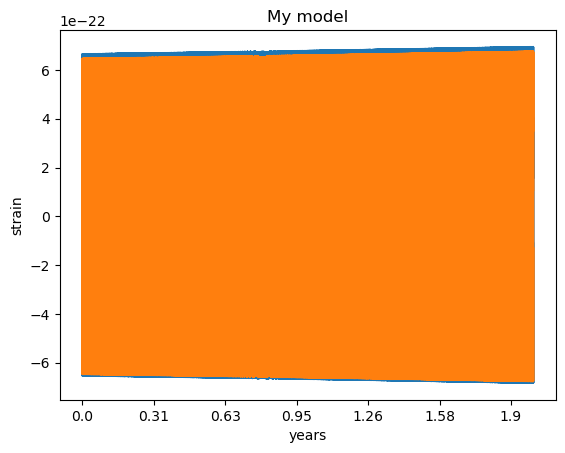

In [8]:
use_gpu = False

# keyword arguments for inspiral generator (RunKerrGenericPn5Inspiral)
inspiral_kwargs = {
    "DENSE_STEPPING": 1,  # we want a densely sampled trajectory
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
}

# keyword arguments for summation generator (AAKSummation)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

wfgenerator = NewPn5AAKWaveform(inspiral_kwargs=inspiral_kwargs, sum_kwargs=sum_kwargs, use_gpu=False)

mywf = wfgenerator(M, mu, a, p0, e0, Y0, qS, phiS, qK, phiK, dist,Phi_phi0=Phi_phi0, Phi_theta0=Phi_theta0, Phi_r0=Phi_r0, mich=mich, dt=dt, T=T)

t = np.arange(len(mywf)) * dt
plt.plot(t, mywf.real);
plt.plot(t, mywf.imag);
plt.title("My model");
ticks = plt.xticks()[0][1:-1];
newlabs = [int(i)/100 for i in (ticks*100/(60*60*24*365))];
plt.xticks(ticks, newlabs);
plt.xlabel("years");
plt.ylabel("strain");

# Mismatch

In [9]:
print("mismatch between FEW AAK waveform and my waveform")
print(get_mismatch(FEWwaveform, mywf))

mismatch between FEW AAK waveform and my waveform
0.9359688374046906


In [10]:
print("mismatch between FEW AAK waveform and test PN waveform")
get_mismatch(FEWwaveform, testwf)

mismatch between FEW AAK waveform and test PN waveform


0.9841169787220546

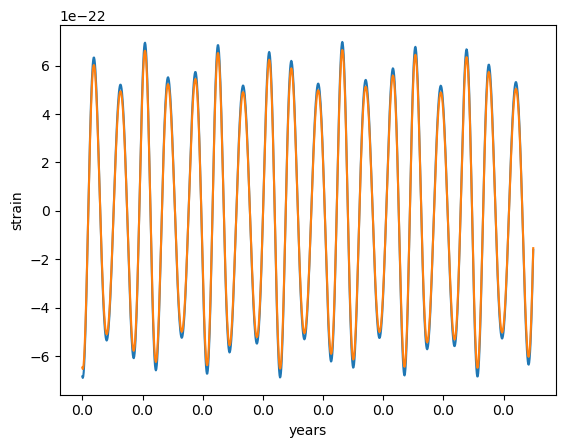

In [11]:
st = 0
stop = 1000
dom = t[st:stop]
ran1 = FEWwaveform.real[st:stop]
#ran2 = testwf.real[st:stop]
ran3 = mywf.real[st:stop]
plt.plot(dom,ran1, label="FEW waveform")
#plt.plot(dom, ran2, label="example PN waveform")
plt.plot(dom, ran3, label="my waveform");
ticks = plt.xticks()[0][1:-1];
newlabs = [int(i)/100 for i in (ticks*100/(60*60*24*365))];
plt.xticks(ticks, newlabs);
plt.xlabel("years");
plt.ylabel("strain");